#A/B-тестирование

### Постановка задачи

Ваша задача — провести оценку результатов A/B-теста. В вашем распоряжении есть датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов.

- Оцените корректность проведения теста
- Проанализируйте результаты теста

Чтобы оценить корректность проведения теста, проверьте:

- пересечение тестовой аудитории с конкурирующим тестом,
- совпадение теста и маркетинговых событий, другие проблемы временных границ теста.

### Техническое задание

- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.

### Описание данных

`ab_project_marketing_events.csv` — календарь маркетинговых событий на 2020 год.

Структура файла:

- `name` — название маркетингового события;
- `regions` — регионы, в которых будет проводиться рекламная кампания;
- `start_dt` — дата начала кампании;
- `finish_dt` — дата завершения кампании.

`final_ab_new_users.csv` — пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `first_date` — дата регистрации;
- `region` — регион пользователя;
- `device` — устройство, с которого происходила регистрация.

`final_ab_events.csv` — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время покупки;
- `event_name` — тип события;
- `details` — дополнительные данные о событии. Например, для покупок, `purchase,` в этом поле хранится стоимость покупки в долларах.

`final_ab_participants.csv` — таблица участников тестов.

Структура файла:

- `user_id` — идентификатор пользователя;
- `ab_test` — название теста;
- `group` — группа пользователя.

##1.Загрузим данные и подготовим к их к анализу

Импортируем все необходимые нам библиотеки, далее новые библиотеки будем добавлять сюда же

In [4]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

import math as mth
from scipy import stats as st

Чтение файлов

In [5]:
# ab_project_marketing_events=pd.read_csv('/datasets/ab_project_marketing_events.csv')
# final_ab_new_users=pd.read_csv('/datasets/final_ab_new_users.csv')
# final_ab_events=pd.read_csv('/datasets/final_ab_events.csv')
# final_ab_participants=pd.read_csv('/datasets/final_ab_participants.csv')

In [6]:
from google.colab import drive
drive.mount('/content/drive')
ab_project_marketing_events=pd.read_csv('/content/drive/MyDrive/Edu/Data Analysis/12_Финальный проект/02_ab_tests/data/ab_project_marketing_events.csv')
final_ab_new_users=pd.read_csv('/content/drive/MyDrive/Edu/Data Analysis/12_Финальный проект/02_ab_tests/data/final_ab_new_users.csv')
final_ab_events=pd.read_csv('/content/drive/MyDrive/Edu/Data Analysis/12_Финальный проект/02_ab_tests/data/final_ab_events.csv')
final_ab_participants=pd.read_csv('/content/drive/MyDrive/Edu/Data Analysis/12_Финальный проект/02_ab_tests/data/final_ab_participants.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
df_list = [ab_project_marketing_events,final_ab_new_users, final_ab_events, final_ab_participants]
for df in df_list:   
    print('Первые 5 строк датафрейма')
    print('-'*80)
    display(df.head(5))
    print('-'*80)
    print('Размер датафрейма: (строк:столбцов) {}'.format(df.shape))
    print('-'*80)
    print('Типы данных и общая информация')
    print(df.info())
    print('-'*80)
    print('Наличие дубликатов: {}'.format(df.duplicated().sum()))
    print('-'*80)
    print('Наличие пропусков')
    print('-'*80)
    print(df.isna().sum())
    print('Стат данные')
    print('-'*80)
    display(df.describe())

Первые 5 строк датафрейма
--------------------------------------------------------------------------------


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


--------------------------------------------------------------------------------
Размер датафрейма: (строк:столбцов) (14, 4)
--------------------------------------------------------------------------------
Типы данных и общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes
None
--------------------------------------------------------------------------------
Наличие дубликатов: 0
--------------------------------------------------------------------------------
Наличие пропусков
--------------------------------------------------------------------------------
name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64
Стат данные
---------

,name,regions,start_dt,finish_dt
count,14,14,14,14
unique,14,6,14,14
top,St. Valentine's Day Giveaway,APAC,2020-07-04,2020-05-03
freq,1,4,1,1


Первые 5 строк датафрейма
--------------------------------------------------------------------------------


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


--------------------------------------------------------------------------------
Размер датафрейма: (строк:столбцов) (61733, 4)
--------------------------------------------------------------------------------
Типы данных и общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB
None
--------------------------------------------------------------------------------
Наличие дубликатов: 0
--------------------------------------------------------------------------------
Наличие пропусков
--------------------------------------------------------------------------------
user_id       0
first_date    0
region        0
device        0
dtype: int64
Стат да

,user_id,first_date,region,device
count,61733,61733,61733,61733
unique,61733,17,4,4
top,A0CD37B38DAF3C00,2020-12-21,EU,Android
freq,1,6290,46270,27520


Первые 5 строк датафрейма
--------------------------------------------------------------------------------


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


--------------------------------------------------------------------------------
Размер датафрейма: (строк:столбцов) (440317, 4)
--------------------------------------------------------------------------------
Типы данных и общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB
None
--------------------------------------------------------------------------------
Наличие дубликатов: 0
--------------------------------------------------------------------------------
Наличие пропусков
--------------------------------------------------------------------------------
user_id            0
event_dt           0
event_name    

,details
count,62740.000000
mean,23.877631
std,72.180465
min,4.990000
25%,4.990000
50%,4.990000
75%,9.990000
max,499.990000


Первые 5 строк датафрейма
--------------------------------------------------------------------------------


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


--------------------------------------------------------------------------------
Размер датафрейма: (строк:столбцов) (18268, 3)
--------------------------------------------------------------------------------
Типы данных и общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB
None
--------------------------------------------------------------------------------
Наличие дубликатов: 0
--------------------------------------------------------------------------------
Наличие пропусков
--------------------------------------------------------------------------------
user_id    0
group      0
ab_test    0
dtype: int64
Стат данные
-------------------------------------------------------------------------

,user_id,group,ab_test
count,18268,18268,18268
unique,16666,2,2
top,84E4D9768D40EFF4,A,interface_eu_test
freq,2,9655,11567


1. Названия столбцов: 
2. Типы данных: необходимо сконвертировать столбцы в формат даты в датасетах events, new_users и ab_events.
3. Дубликаты: отсутствуют.
4. Пропуски: в датасете ab_events в колонке `details` в количестве 377 577 шт. - для покупок в этом поле хранится стоимость покупки в долларах, пропуски обусловлены тем, что не все события являются покупкой
5. Аномалии в данных: на первый взгляд отсутствуют.

Сконвертируем столбцы в формат даты в датасетах events, new_users и ab_events

In [8]:
ab_project_marketing_events['start_dt'] = ab_project_marketing_events['start_dt'].astype('datetime64[s]')
ab_project_marketing_events['finish_dt'] = ab_project_marketing_events['finish_dt'].astype('datetime64[s]')
final_ab_new_users['first_date'] = final_ab_new_users['first_date'].astype('datetime64[s]')
final_ab_events['event_dt']=final_ab_events['event_dt'].astype('datetime64[s]')

In [9]:
df_list = [ab_project_marketing_events,final_ab_new_users, final_ab_events]
for df in df_list:   
    print('Типы данных и общая информация')
    print(df.info())

Типы данных и общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes
None
Типы данных и общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     61733 non-null  object        
 1   first_date  61733 non-null  datetime64[ns]
 2   region      61733 non-null  object        
 3   device      61733 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.9+ MB
None
Типы данных и общая инфор

##2.Проведем исследовательский анализ данных

###2.1. Исследование выборки

In [10]:
final_ab_participants.groupby('ab_test').nunique()

,user_id,group
ab_test,,
interface_eu_test,11567,2
recommender_system_test,6701,2


В таблице участников тестов содержатся данные по двум тестам: recommender_system_test на 6701 пользователей и interface_eu_test на 11567 пользователей.

Проверим принадлежность пользователей к участию в обоих тестах:

In [11]:
print('Таких пользователей -', final_ab_participants.groupby('user_id')['ab_test'].nunique().reset_index().query('ab_test > 1').count().iloc[0])

Таких пользователей - 1602


Так как одновременное присутствие пользователей сразу в обоих тестах может привести к искажениям при дальнейшем анализе, то удалим их, а также все данные по тесту, который нам не нужен - interface_eu_test:

In [12]:
doubled_users=final_ab_participants.groupby('user_id')['ab_test'].nunique().reset_index().query('ab_test > 1')['user_id'].to_list()
recommender_system_test_users=final_ab_participants.query('ab_test == "recommender_system_test" & user_id not in @doubled_users').drop('ab_test', axis = 1)

Теперь проверим нет ли пересечений пользователей между группами А и В:

In [13]:
a = list(recommender_system_test_users.query('group == "A"')['user_id'])
b = list(recommender_system_test_users.query('group == "B"')['user_id'])
result = [id for id in a if id in b]
print('Количество пересекающихся пользователей: {:.0f}'.format(len(result)))

Количество пересекающихся пользователей: 0


###2.2. Исследование аудитории

Нас интересуют только пользователи теста recommender_system_test:

In [14]:
ab_users=pd.merge(recommender_system_test_users,final_ab_new_users,on='user_id',how='left')

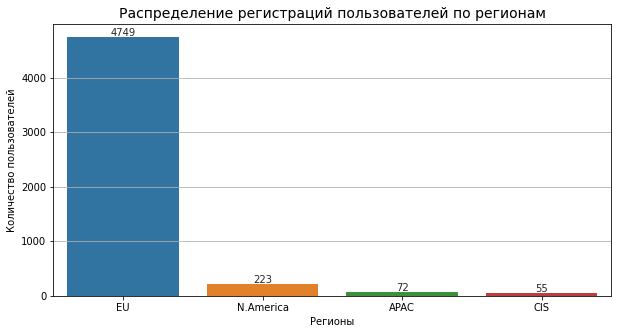

In [15]:
plt.figure(figsize=(10, 5))
plt.grid(True)
plt.title('Распределение регистраций пользователей по регионам', size=14)
plot = sns.barplot(data = ab_users['region'].value_counts().reset_index(), x = 'index', y = 'region')
sns.set_style("whitegrid", {'axes.grid' : False})
for p in plot.patches:
    plot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 4), 
                   textcoords = 'offset points')
plt.ylabel('Количество пользователей')
plt.xlabel('Регионы')
plt.show()

In [16]:
print('Пользователей из региона EU в экперементальной выборке по отношению ко всем пользователям из EU - {:.2%}'\
            . format(ab_users[ab_users['region'] == 'EU']['user_id']\
            .count() / final_ab_new_users[final_ab_new_users['region']=='EU']['user_id'].count()))

Пользователей из региона EU в экперементальной выборке по отношению ко всем пользователям из EU - 10.26%


###2.3. Исследование событий

Таблицу с событиями также отфильтруем только по нужным пользователям:

In [17]:
ab_events = pd.merge(recommender_system_test_users, final_ab_events, on = 'user_id', how = 'inner')

In [18]:
print('В среднем 1 пользователь совершает {:.0f} событий'.format(ab_events.groupby('user_id')['event_name'].count().mean()))

В среднем 1 пользователь совершает 7 событий


Посмотрим на распределение количества событий пользователей по времени.

Выделим дату из временного столбца `event_dt`:

In [19]:
ab_events['event_dt'] = ab_events['event_dt'].dt.date
ab_events['event_dt'] = pd.to_datetime(ab_events['event_dt'])

In [20]:
ab_events.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18804 entries, 0 to 18803
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     18804 non-null  object        
 1   group       18804 non-null  object        
 2   event_dt    18804 non-null  datetime64[ns]
 3   event_name  18804 non-null  object        
 4   details     2483 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 881.4+ KB


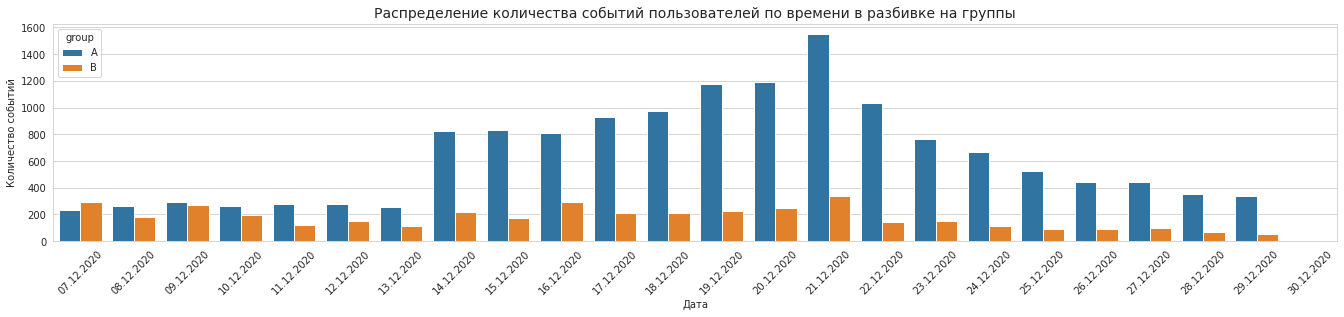

In [21]:
plot=ab_events.groupby(['event_dt', 'group'])['user_id'].count().reset_index()
plot.index = plot['event_dt']

plt.figure(figsize = (23, 4))
plt.grid(True)
plt.title('Распределение количества событий пользователей по времени в разбивке на группы', size=14)
sns.barplot(data = plot, x = plot.index.strftime('%d.%m.%Y'), y = 'user_id', hue = 'group')
plt.ylabel('Количество событий')
plt.xlabel('Дата')
plt.xticks(rotation = 45)
plt.show()

На графике наблюдаем увеличение активности пользователей в период с 14.12.2020 по 26.12.2020 гг., что может быть вызвано сезонностью. Также отмечаем, что группа А скакнула посильнее, чем В. В начале они шло почти ровно.

Также дополнительно посмотрим календарь маркетинговых событий во временной период проведения теста:

In [22]:
ab_project_marketing_events.query('start_dt >="2020-12-07" & finish_dt >="2020-12-30"')

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


В период попали два маркетинговых события, а соответственно пользовательские события за эти даты из выборки необходимо удалить:

In [23]:
ab_events_clean=ab_events.loc[(ab_events['event_dt'] < '2020-12-25')]

In [24]:
print('Всего было удалено {:.2%} событий.' \
      .format((ab_events['event_dt'].count() - ab_events_clean['event_dt'].count()) / ab_events['event_dt'].count()))

Всего было удалено 13.32% событий.


Распределение событий по тестовым группам:

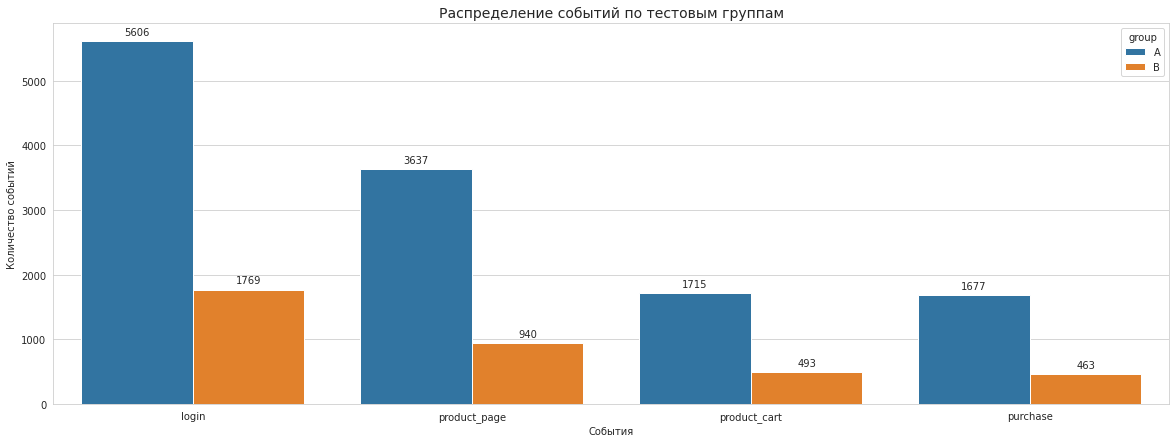

In [25]:
plt.figure(figsize = (20, 7))
plt.grid(True)
plt.title('Распределение событий по тестовым группам', size=14)
plot = sns.countplot(data = ab_events_clean, x = 'event_name', hue = 'group', order = ab_events_clean['event_name'].value_counts().index)
for p in plot.patches:
    plot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.ylabel('Количество событий')
plt.xlabel('События')
plt.show()

* Как меняется конверсия в воронке на разных этапах?



Последовательность цепочки событий выстраивается следующим образом: login → product_page → product_cart → purchase.

Посмотрим на воронку событий по группам А и В:

In [26]:
fun_a = ab_events_clean.query('group == "A"')\
                .groupby('event_name')['user_id'].nunique().reset_index().sort_values('user_id', ascending = False)
fun_b = ab_events_clean.query('group == "B"')\
                .groupby('event_name')['user_id'].nunique().reset_index().sort_values('user_id', ascending = False)

In [27]:
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'A',
    y = fun_a['event_name'],
    x = fun_a['user_id'],
    textinfo = "value+percent previous"))

fig.add_trace(go.Funnel(
    name = 'B',
    y = fun_b['event_name'],
    x = fun_b['user_id'],
    textinfo = "value+percent previous"))

fig.update_layout(
    title = {
        'text' : 'Конверсия событий пользователей по группам А и В)',
        'x':0.5
    }
)

fig.show()

На основании воронки видим, что небольшая доля пользователей производят покупку в обход "корзины", возможно по причине того, что выбирают "покупка в 1 клик".

Полностью воронку событий проходит в среднем по группам 30 % пользователей.

## 3.Оценим результаты A/B-тестирования

###3.1. Анализ количества пользователей по экспериментальным группам

In [28]:
print('Всего уникальных пользователей - {:.0f}' .format(ab_events_clean['user_id'].nunique()))

Всего уникальных пользователей - 2788


Посмотрим на количество пользователей в каждой экспериментальной группе в разрезе событий:

In [29]:
events_by_groups = ab_events_clean\
                    .pivot_table(index = 'event_name', columns = 'group', values = 'user_id', aggfunc = 'nunique')\
                    .sort_values('A', ascending = False)

In [30]:
events_by_groups

group,A,B
event_name,,
login,2082,705
product_page,1360,397
purchase,652,198
product_cart,631,195


Размеры групп различаются, что говорит о неоптимальности разбиения данных по группам.

Для будущих тестов следует несколько поработать с механикой выделения групп и, возможно, изменить подход к их выделению.

###3.2. Статистическая разница между контрольными группами

При проверке гипотез о равенстве среднего будем применять метод Z-тест (z-критерий Фишера), т.к. будем проводить сравнения двух независимых выборок большого размера. Критический уровень статистической значимости примем равным 5%. Создадим функцию с применением поправки Бонферрони:

In [31]:
def z_test(group_1, group_2, eventname, alpha): 
    purchases1 = events_by_groups.loc[eventname, group_1]
    purchases2 = events_by_groups.loc[eventname, group_2]
    n1 = events_by_groups.iloc[0, 0]
    n2 = events_by_groups.iloc[0, 1]
    p1 = purchases1 / n1    
    p2 = purchases2 / n2     
    difference = p1 - p2    
    p_combined = (purchases1 + purchases2) / (n1 + n2)    
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1 / n1 + 1 / n2))                
    distr = st.norm(0, 1)    
    p_value = (1 - distr.cdf(abs(z_value))) * 2

    bonferroni_alpha = alpha / 4
    
    print('Проверка события:', eventname)
    print('p-value: ',p_value)
   
    if (p_value < bonferroni_alpha):
        print("Отвергаем нулевую гипотезу: между конверсией групп есть значимая разница")
    else:
        print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсию групп разной") 
    print('')

In [32]:
for eventname in events_by_groups.index:
    z_test('A', 'B', eventname, 0.05)

Проверка события: login
p-value:  nan
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсию групп разной

Проверка события: product_page
p-value:  1.8387132766806147e-05
Отвергаем нулевую гипотезу: между конверсией групп есть значимая разница

Проверка события: purchase
p-value:  0.1072913801985722
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсию групп разной

Проверка события: product_cart
p-value:  0.18330462936588865
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсию групп разной



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning:

invalid value encountered in double_scalars



Для события `login`, проверка статистической разницы долей z-критерием невозможна, так как это действие совершили все пользователи группы А и группы В, а это число соответствует максимальному размеру выборки групп.

Значимая статистическая разница в конверсии групп А и В присутствует только для события `product_page`.

## 4.Опишем выводы по этапу исследовательского анализа данных и по проведённой оценке результатов A/B-тестирования

В результате анализа проведенного А/В-тестирования были выявлены следующие недочеты по пунктам ТЗ:

- отсутствуют события в диапазоне с 2020-12-31 по 2021-01-04;
- аудитория: вместо 15% новых пользователей из региона EU было только 10 %, а также присутствовало небольшое количество пользователей из других регионов;
- ожидаемое количество участников теста: 6000 - по факту только 2788;
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page` - по факту ухудшение на 9 %,
    - просмотры корзины — `product_cart` - по факту улучшение на 1 %,
    - покупки — `purchase` - по факту улучшение на 2 %.

Дополнительные недочеты:

- одновременно с тестом `recommender_system_test` проходил тест `interface_eu_test`;
- 1602 пользователя теста `recommender_system_test` также попали в тест `interface_eu_test`;
- время период проведения теста совпало с двумя маркетинговыми событиями, что могло повлиять на активность пользователей;
- неравномерное распределение по группам А и В;
- нарушена логическая последовательность событий: часть пользователей оплатили покупку минуя просмотр корзины товаров.

Рекомендации: учесть выявленные недочеты и доработать механизм и методику проведения теста.